# Goal

跑通 MVP，拿到 baseline 模型。作为优化的基础。

# 训练细节

1. 已下载的数据较多。从 porn / sexy / neutral 中各取 2k 张训练。
    - train count: 18000
    - valid count: 9000
    - test count: 3000

2. accuracy: 存在较为严重的过拟合
    - training accuracy: 90%
    - validation accuracy: 66%
3. epochs: 5
4. timecost
    - 74s/epoch
    - 3s/step

# Next Steps

1. 一边读大图，一边 resize，训练太慢。尝试用 tf.records 优化 或者预先 resize 图片
2. noisy label 很多，试一下 learning with noisy label (LNL) 模型

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.1.0'

# Load Datasets

手动清洗 10k 以下的无效图片

~/datasets/nsfw_data_scraper/raw_data/data$ find . -type f -size -10k -exec mv {} ../invalid/ \;

In [2]:
DATA_DIR = '/home/jackon/datasets/nsfw_data_scraper/raw_data/data'
# classes = ['drawings', 'hentai', 'neutral', 'porn', 'sexy']
labels = ['neutral', 'porn', 'sexy']
MAX_COUNT_PER_LABEL = 1000

In [3]:
def read_label_images(label):
    filepath = os.path.join(DATA_DIR, label)
    files = os.listdir(filepath)
    df1 = pd.DataFrame([os.path.join(DATA_DIR, label, f) for f in files])
    df1['label'] = label
    df1.columns = ['file', 'label']
    return df1

# df = read_label_images('sexy')
# df.head()

In [4]:
from PIL import Image


def preview_images(df, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 20))
    for i, img_idx in enumerate(range(min(len(df), nrow * ncol))):
        item = df.iloc[i]
        image_obj = Image.open(item['file'])
        w, h = image_obj.size
        ax = axes.flat[i]
        ax.imshow(image_obj)
#         ax.set_title('pred: {}'.format(
#             ''.join(map(lambda i: b[i], y_pred[img_idx].numpy()))))
        ax.set_xlabel('true: {}. size: {} * {}'.format(item['label'], w, h))
        ax.set_xticks([])
        ax.set_yticks([])
# preview_images(df)

In [5]:
# read all images
from sklearn.utils import shuffle

df = pd.concat(read_label_images(label)[:MAX_COUNT_PER_LABEL] for label in labels)
df = shuffle(df)
df.head()

,file,label
113,/home/jackon/datasets/nsfw_data_scraper/raw_da...,neutral
743,/home/jackon/datasets/nsfw_data_scraper/raw_da...,sexy
101,/home/jackon/datasets/nsfw_data_scraper/raw_da...,porn
596,/home/jackon/datasets/nsfw_data_scraper/raw_da...,sexy
338,/home/jackon/datasets/nsfw_data_scraper/raw_da...,neutral


In [6]:
p = np.arange(len(df))

RATIO = 1

total = int(len(df) * RATIO)
train_up_to = int(total * 0.6)
valid_idx_to = int(total * 0.9)

train_idx = p[:train_up_to]
valid_idx = p[train_up_to:valid_idx_to]
test_idx = p[valid_idx_to:total]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 1800, valid count: 900, test count: 300


In [7]:
df[:total]['label'].value_counts()

porn       1000
neutral    1000
sexy       1000
Name: label, dtype: int64

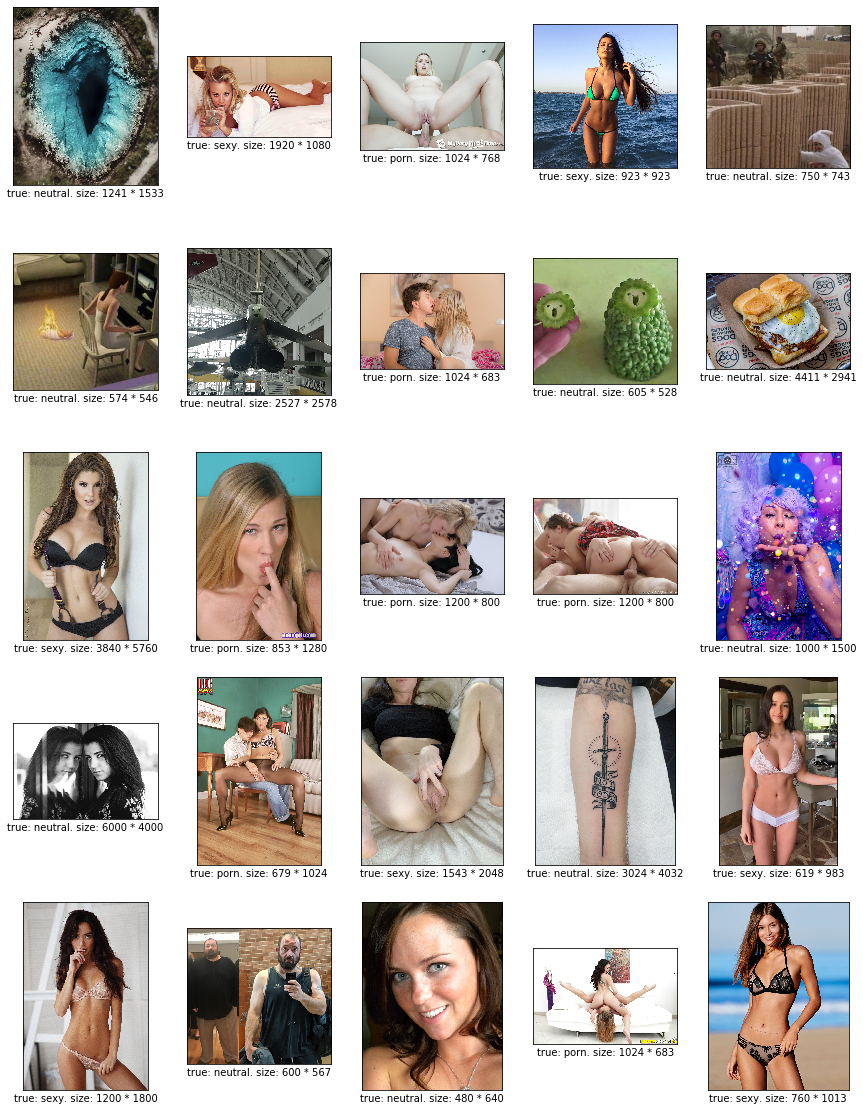

In [8]:
preview_images(df)

# label mapping

In [9]:
label2idx = {
    label: idx for idx, label in enumerate(labels)
}
label2idx

{'neutral': 0, 'porn': 1, 'sexy': 2}

In [10]:
idx2label = {
    idx: label for label, idx in label2idx.items()
}
idx2label

{0: 'neutral', 1: 'porn', 2: 'sexy'}

In [11]:
W, H, C = 256, 256, 3  # resized to 256x256 pixels
N_LABELS = len(labels)

In [12]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            try:
                im = Image.open(file)
                if im.mode != 'RGB':
                    im = im.convert('RGB')
            except Exception as e:
                print('error image: %s' % file)
                print(e)
                continue

            im = im.resize((H, W))
            im = np.array(im) / 255.0
            if len(im.shape) != 3:
                print(im.shape)
                continue
            images.append(np.array(im))
            labels.append(np.array(
                to_categorical(label2idx[label], N_LABELS)
            ))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [13]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model


def conv_block(input_data, filters=32, bn=True, pool=True, kernel_size=3, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation)(input_data)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(N_LABELS, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0     

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 14 steps
Epoch 1/5
28/28 [==============================] - 90s 3s/step - loss: 1.8244 - accuracy: 0.3622 - val_loss: 1.0496 - val_accuracy: 0.3962
Epoch 2/5
28/28 [==============================] - 74s 3s/step - loss: 0.9668 - accuracy: 0.5352 - val_loss: 0.9125 - val_accuracy: 0.5826
Epoch 3/5
28/28 [==============================] - 74s 3s/step - loss: 0.7904 - accuracy: 0.6367 - val_loss: 0.8225 - val_accuracy: 0.6484
Epoch 4/5
28/28 [==============================] - 74s 3s/step - loss: 0.6225 - accuracy: 0.7372 - val_loss: 0.8411 - val_accuracy: 0.6607
Epoch 5/5
28/28 [==============================] - 74s 3s/step - loss: 0.5392 - accuracy: 0.7885 - val_loss: 0.9053 - val_accuracy: 0.6406


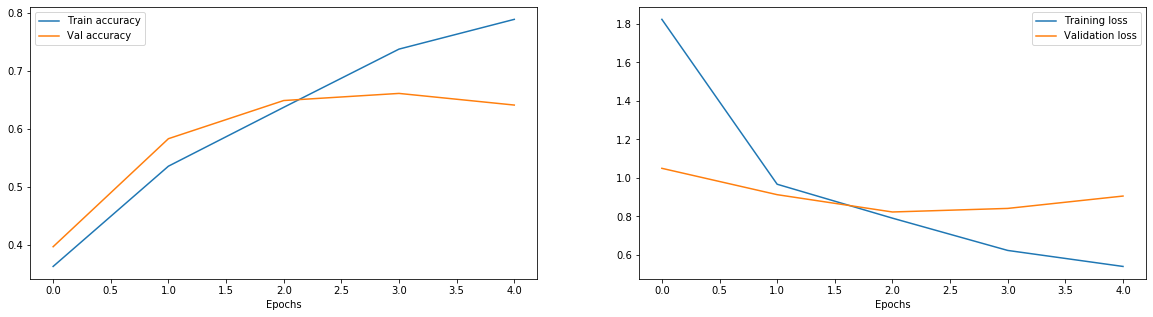

In [15]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [16]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

  ...
    to  
  ['...']
2/2 [==============================] - 5s 2s/step - loss: 0.8294 - accuracy: 0.6641


{'loss': 0.829428493976593, 'accuracy': 0.6640625}

In [17]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

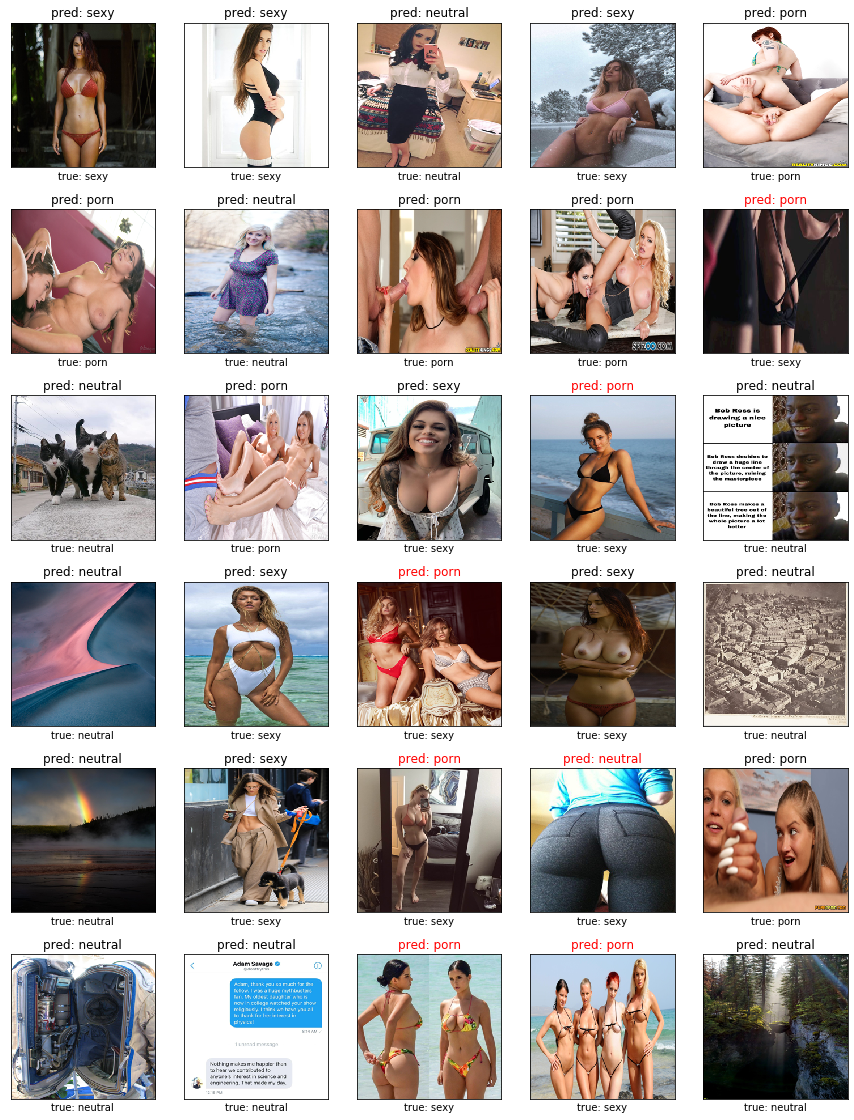

In [19]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    pred = idx2label[y_pred[img_idx].numpy()]
    ground_truth = idx2label[y_true[img_idx].numpy()]
    if pred != ground_truth:
        color = 'r'
    else:
        color = 'k'
    ax.set_title('pred: {}'.format(pred), color=color)
    ax.set_xlabel('true: {}'.format(ground_truth))
    ax.set_xticks([])
    ax.set_yticks([])